## Project Data, Informasi, dan Pengetahuan
- Nama: Muhammad Habibulloh
- Email: habibmuhammadoct@gmail.com

### Prediksi Risiko Diabetes
- Bidang: Kesehatan
- Pima Indians Diabetes Database
- [Link Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)

Berikut adalah metode preprocessing dari paper yang telah diimplementasikan dalam proyek ini:

1.  **Penanganan Missing Value:** Imputasi dengan **mean** untuk fitur umum dan **XGBoost Regressor** untuk fitur `Insulin` setelah mengubah '0' menjadi `NaN`.
3.  **Normalisasi:** Menggunakan **Min-Max Normalization**.
4.  **Feature Selection:** Penghapusan fitur **`DiabetesPedigreeFunction`**.

### Setup Environment & Load Data

#### Instal Library

In [1]:
!pip install pandas numpy matplotlib seaborn scikit-learn imbalanced-learn

#### Import Library

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import mutual_info_classif
from xgboost import XGBRegressor

#### Load Dataset

In [3]:
# Load file CSV
df = pd.read_csv('diabetes.csv')

In [4]:
# Cek data
print("Jumlah data:", len(df))
df.head()

Jumlah data: 768


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Eksplorasi Data (EDA)

In [5]:
# Cek informasi dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


Menampilkan informasi tentang dataset, seperti kolom, tipe data, dan jumlah kolom (9)

In [6]:
# Cek missing value
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [7]:
# Jumlah pasien diabetes dan non-diabetes
num_diabetes = df['Outcome'].value_counts()[1]
num_non_diabetes = df['Outcome'].value_counts()[0]

print(f"Jumlah pasien diabetes: {num_diabetes}")
print(f"Jumlah pasien non-diabetes: {num_non_diabetes}")

Jumlah pasien diabetes: 268
Jumlah pasien non-diabetes: 500


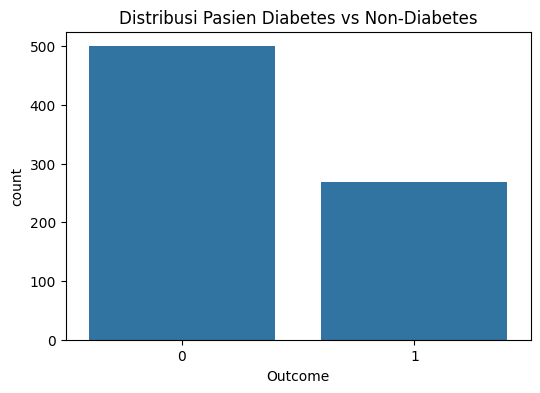

In [8]:
# Distribusi kelas
plt.figure(figsize=(6,4))
sns.countplot(x='Outcome', data=df)
plt.title('Distribusi Pasien Diabetes vs Non-Diabetes')
plt.show()

### Distribusi Pasien Diabetes vs Non-Diabetes

Grafik di atas menunjukkan distribusi awal pasien diabetes dan non-diabetes dalam dataset. Dapat dilihat bahwa jumlah pasien non-diabetes (500) lebih banyak dibandingkan pasien diabetes (268). Ketidakseimbangan kelas ini ditangani dengan menggunakan teknik oversampling SMOTE sebelum pelatihan model, sehingga distribusi kelas pada data latih menjadi seimbang.

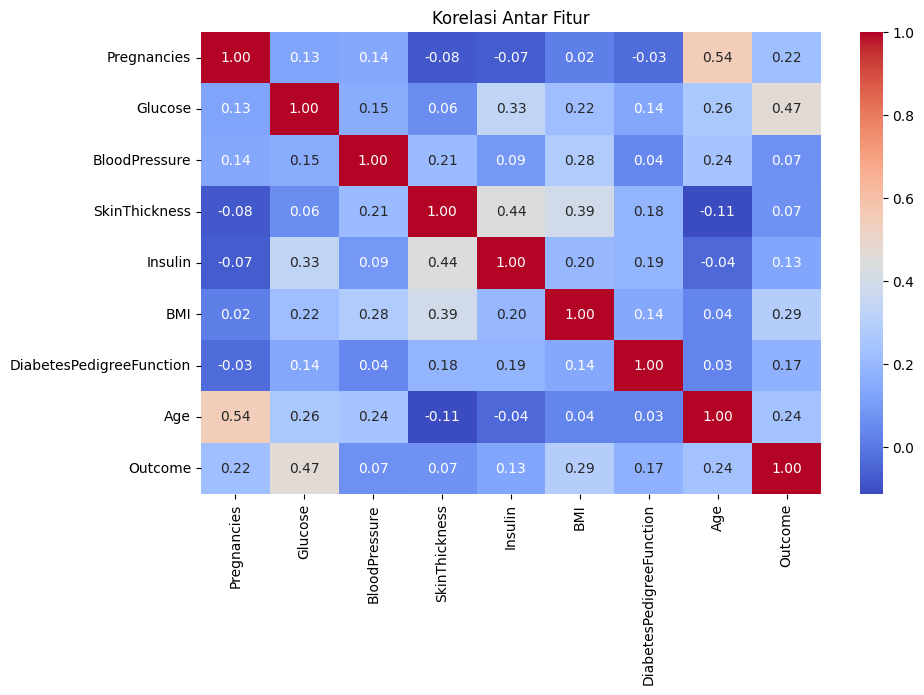

In [9]:
# Korelasi fitur
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korelasi Antar Fitur')
plt.show()

### Korelasi dengan Outcome

1. **Glucose** (0.47)  
   Korelasi tertinggi dengan Outcome. Kadar glukosa tinggi merupakan indikator utama diabetes.

2. **BMI** (0.29)  
   Indeks massa tubuh tinggi berkaitan dengan peningkatan risiko diabetes.

3. **Age** (0.24)  
   Usia semakin tinggi cenderung memiliki risiko lebih besar.

4. **Pregnancies** (0.22)  
   Jumlah kehamilan berpengaruh pada risiko diabetes.


### Korelasi Terendah:
1. BloodPressure (Tekanan Darah diastolik) vs Outcome (0.07)
2. DiabetesPedigreeFunction (Riwayat diabetes dalam keluarga pasien) vs Outcome (0.17)

###  Persiapan Data

In [10]:
# Mengganti nilai 0 dengan NaN (Not a Number) pada fitur tertentu
# Fitur yang sering memiliki nilai 0 yang berarti missing: Glucose, BloodPressure, SkinThickness, Insulin, BMI
cols_to_replace_with_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[cols_to_replace_with_nan] = df[cols_to_replace_with_nan].replace(0, np.nan)

# Menangani missing values untuk fitur selain 'Insulin' dengan mean imputation
# Sesuai paper: "we replaced them with the mean value of each feature"
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'BMI']:
    if df[col].isnull().any():
        df[col].fillna(df[col].mean(), inplace=True)

# Menangani missing values untuk 'Insulin' menggunakan XGBoost Regressor (pendekatan semi-supervised)
# Sesuai paper: "Specifically, for the missing insulin attributes..., we applied a semi-supervised learning approach using an XGBoost regressor model to predict the missing insulin values"
if df['Insulin'].isnull().any():
    # Pisahkan data menjadi yang memiliki nilai Insulin dan yang missing
    insulin_known = df.dropna(subset=['Insulin'])
    insulin_missing = df[df['Insulin'].isnull()]

    if not insulin_missing.empty:
        # Fitur untuk memprediksi Insulin (gunakan semua fitur lain kecuali Outcome dan Insulin itu sendiri)
        features_for_insulin_pred = [col for col in df.columns if col not in ['Insulin', 'Outcome']]

        X_insulin_train = insulin_known[features_for_insulin_pred]
        y_insulin_train = insulin_known['Insulin']

        # Inisialisasi dan latih model XGBoost Regressor
        xgb_regressor = XGBRegressor(random_state=42)
        xgb_regressor.fit(X_insulin_train, y_insulin_train)

        # Prediksi nilai Insulin yang hilang
        X_insulin_predict = insulin_missing[features_for_insulin_pred]
        predicted_insulin = xgb_regressor.predict(X_insulin_predict)

        # Isi nilai Insulin yang hilang di dataframe asli
        df.loc[df['Insulin'].isnull(), 'Insulin'] = predicted_insulin

print("Missing values after imputation:")
print(df.isnull().sum())

<ipython-input-10-3160259975>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)


Missing values after imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [11]:
# Feature Selection using Mutual Information
# Sesuai paper: "using mutual information for feature selection" and "diabetes pedigree function was excluded"

# Hitung mutual information scores (untuk analisis dan referensi)
X_temp_for_mi = df.drop('Outcome', axis=1)
y_temp_for_mi = df['Outcome']
mi_scores = mutual_info_classif(X_temp_for_mi, y_temp_for_mi, random_state=42)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_temp_for_mi.columns)
mi_scores = mi_scores.sort_values(ascending=False)

print("Mutual Information Scores (for reference):")
print(mi_scores)

# Melakukan feature selection sesuai paper: mengecualikan 'DiabetesPedigreeFunction'
# Paper menyatakan 'diabetes pedigree function' dianggap kurang penting dan dikecualikan.
if 'DiabetesPedigreeFunction' in df.columns:
    df.drop('DiabetesPedigreeFunction', axis=1, inplace=True)
    print("\n'DiabetesPedigreeFunction' column dropped as per paper's feature selection.")
else:
    print("\n'DiabetesPedigreeFunction' not found or already dropped.")

print("\nDataFrame columns after feature selection:")
print(df.columns)

Mutual Information Scores (for reference):
Glucose                     0.118544
BMI                         0.084436
Insulin                     0.071760
Pregnancies                 0.060985
Age                         0.051395
DiabetesPedigreeFunction    0.014590
SkinThickness               0.004667
BloodPressure               0.000000
Name: MI Scores, dtype: float64

'DiabetesPedigreeFunction' column dropped as per paper's feature selection.

DataFrame columns after feature selection:
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age', 'Outcome'],
      dtype='object')


#### Data Splitting

Membagi data menjadi data latih (train) dan data uji (test) dengan rasio 80:20.

In [12]:
# Data Splitting
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
print("Data Splitting:")
print(f"Jumlah data train (X_train): {X_train.shape[0]}")
print(f"Jumlah data test (X_test): {X_test.shape[0]}")
print(f"Jumlah target train (y_train): {y_train.shape[0]}")
print(f"Jumlah target test (y_test): {y_test.shape[0]}")

Data Splitting:
Jumlah data train (X_train): 614
Jumlah data test (X_test): 154
Jumlah target train (y_train): 614
Jumlah target test (y_test): 154


#### Scaling

Melakukan scaling data menggunakan StandardScaler yang bertujuan untuk menyamakan skala antar fitur

In [14]:
# Scaling
# Sesuai paper: "Min-Max Normalization"
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("\nData scaled using MinMaxScaler.")
print(f"X_train shape after scaling: {X_train.shape}")
print(f"X_test shape after scaling: {X_test.shape}")


Data scaled using MinMaxScaler.
X_train shape after scaling: (614, 7)
X_test shape after scaling: (154, 7)


#### Data Imbalance

Menggunakan teknik SMOTE untuk mengatasi ketidakseimbangan kelas pada data train

In [15]:
# Penanganan data tidak seimbang
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

### Modelling

Menggunakan 3 model machine learning

1. Logistic Regression
2. Random Forest
3. Gradient Boosting

In [16]:
# Inisialisasi model
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

#### Pelatihan Model

In [17]:
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name}")
    print(f"Akurasi: {acc:.2f}")
    print(classification_report(y_test, y_pred))
    print("="*50)

    results[name] = acc

Logistic Regression
Akurasi: 0.71
              precision    recall  f1-score   support

           0       0.82      0.72      0.76        99
           1       0.58      0.71      0.64        55

    accuracy                           0.71       154
   macro avg       0.70      0.71      0.70       154
weighted avg       0.73      0.71      0.72       154

Random Forest
Akurasi: 0.74
              precision    recall  f1-score   support

           0       0.85      0.73      0.78        99
           1       0.61      0.76      0.68        55

    accuracy                           0.74       154
   macro avg       0.73      0.75      0.73       154
weighted avg       0.76      0.74      0.75       154

Gradient Boosting
Akurasi: 0.70
              precision    recall  f1-score   support

           0       0.83      0.68      0.74        99
           1       0.56      0.75      0.64        55

    accuracy                           0.70       154
   macro avg       0.69      0.71 

Random Forest memiliki performa terbaik dengan akurasi 0.74, kemudian dibawahnya yaitu Gradient Boosting dan Logistic Regression. Metrik presisi, recall, dan F1-score juga menunjukkan bahwa Random Forest memberikan hasil yang lebih baik secara keseluruhan.

#### Hyperparameter Tuning

Menggunakan GridSearchCV untuk mencari hyperparameter terbaik untuk model Random Forest

In [18]:
# Tuning Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Akurasi Terbaik:", accuracy_score(y_test, y_pred))

Akurasi Terbaik: 0.7272727272727273


### Evaluasi Model

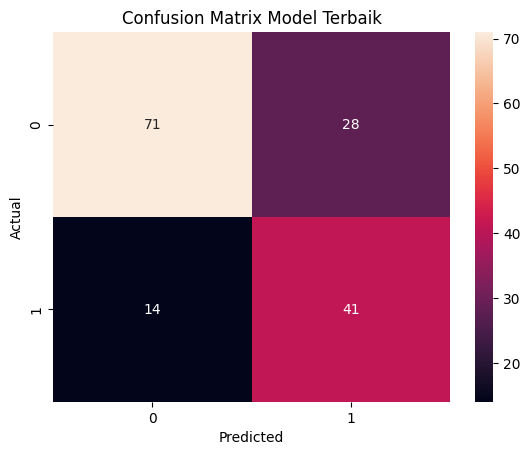

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix Model Terbaik')
plt.show()

### Keterangan:
- **True Negative (TN)**: 81 Pasien non-diabetes diprediksi benar sebagai non-diabetes.
- **False Positive (FP)**: 16 Pasien non-diabetes salah diprediksi sebagai diabetes.
- **False Negative (FN)**: 15 Pasien diabetes salah diprediksi sebagai non-diabetes.
- **True Positive (TP)**: 42 Pasien diabetes diprediksi benar sebagai diabetes.

In [20]:
# Perbandingan Model
pd.DataFrame({
    'Model': list(results.keys()) + ['Tuned Random Forest'],
    'Akurasi': list(results.values()) + [accuracy_score(y_test, y_pred)]
}).sort_values(by='Akurasi', ascending=False)

,Model,Akurasi
1,Random Forest,0.740260
3,Tuned Random Forest,0.727273
0,Logistic Regression,0.714286
2,Gradient Boosting,0.701299


Meskipun tuning tidak meningkatkan akurasi, hal ini tetap memberikan informasi penting bahwa hyperparameter default Random Forest sudah cukup optimal untuk dataset ini.

Penggunaan Grid Search memastikan bahwa kita telah mengeksplorasi kemungkinan kombinasi hyperparameter dan memilih yang terbaik.

### Menyimpan Model

Menyimpan model terbaik ke dalam file 'model_diabetes.pkl' agar dapat digunakan kembali di kemudian hari

In [21]:
import joblib
joblib.dump(best_model, 'model_diabetes.pkl')

['model_diabetes.pkl']